# Generate an ANOVA boxplot for gene expression levels

In [1]:
import pandas as pd
import numpy as np
import pickle
import pingouin as pg
import matplotlib.pyplot as plt

## Define the gene, dataset and groups of interest to plot

In [2]:
gene_name = 'SMYD2'
dataset_name = 'TCGA-BRCA'
group_names = ['NT', 'Luminal-A', 'Luminal-B', 'HER2-enriched', 'Basal-like']

## Import a project

In [3]:
pickle_file = 'data/LysOnc.pickle'
with open(pickle_file, 'rb') as f:
    project = pickle.load(f)

## Load data

In [4]:
data_file = project['data_dir'] + project['datasets'][dataset_name]['data']
data = pd.read_csv(data_file, sep=';')
data.index = data['gene_symbol']
if 'id_gene' in data.columns:
    data.drop(columns=['id_gene', 'gene_symbol'], inplace=True)
data.head()

,TCGA-3C-AAAU-01A,TCGA-3C-AALI-01A,TCGA-3C-AALJ-01A,TCGA-3C-AALK-01A,TCGA-4H-AAAK-01A,TCGA-5L-AAT0-01A,TCGA-5L-AAT1-01A,TCGA-5T-A9QA-01A,TCGA-A1-A0SB-01A,TCGA-A1-A0SD-01A,...,TCGA-UL-AAZ6-01A,TCGA-UU-A93S-01A,TCGA-V7-A7HQ-01A,TCGA-W8-A86G-01A,TCGA-WT-AB41-01A,TCGA-WT-AB44-01A,TCGA-XX-A899-01A,TCGA-XX-A89A-01A,TCGA-Z7-A8R5-01A,TCGA-Z7-A8R6-01A
gene_symbol,,,,,,,,,,,,,,,,,,,,,
ACAD9,3.443010,3.378234,3.410165,3.517439,3.494249,3.553496,3.576522,3.621126,3.304146,3.464956,...,3.514324,3.744753,3.583952,3.533464,2.657228,3.340163,3.357468,3.501044,3.553901,3.733680
ACTBL2,0.064055,0.014212,0.000000,0.020058,0.054501,0.000000,0.043204,0.000000,0.289952,0.026021,...,0.009060,0.000000,0.000000,0.110096,0.000000,0.000000,1.566328,0.022616,0.085425,0.019346
ACTC1,0.211884,0.000000,0.056722,0.012211,0.013498,0.037453,0.052555,0.019061,1.838185,0.208268,...,0.022190,0.000000,0.000000,0.015498,0.067363,0.043064,0.037734,0.000000,0.246104,0.069702
AHNAK,7.186134,5.957148,5.561650,6.006008,6.885628,6.640573,5.702599,5.349263,6.622119,6.723016,...,4.959840,4.353824,5.183995,6.251443,5.132782,4.996484,6.347690,6.429745,5.392860,6.607653
ARHGEF5,2.802131,1.682798,1.795684,2.092850,2.050362,2.244248,1.797387,1.986520,2.174151,2.304803,...,1.951998,2.583760,2.461529,2.681044,2.635429,2.322332,1.972068,1.402395,2.479955,1.906236


## Extract the data corresponding to genes and groups

In [5]:
boxplot_data = []
anova_data = pd.DataFrame()
for group_name in group_names:
    group_samples = project['datasets'][dataset_name]['groups'][group_name]
    print(dataset_name, group_name, len(group_samples))
    boxplot_data.append(data.loc[gene_name, group_samples])
    for group_sample in group_samples: 
        anova_data.loc[group_sample, gene_name] = data.loc[gene_name, group_sample]
    anova_data.loc[group_samples, 'group_name'] = group_name        

TCGA-BRCA NT 113
TCGA-BRCA Luminal-A 547
TCGA-BRCA Luminal-B 202
TCGA-BRCA HER2-enriched 82
TCGA-BRCA Basal-like 193


In [6]:
anova_data.head()

,SMYD2,group_name
TCGA-A7-A0CE-11A,3.239413,NT
TCGA-A7-A0CH-11A,3.269527,NT
TCGA-A7-A0D9-11A,2.917451,NT
TCGA-A7-A0DB-11A,2.805499,NT
TCGA-A7-A0DC-11A,3.069238,NT


## Perform ANOVA

Options:
* dv: name of the column containing the dependant variables
* between: name of the column containing the between-group factor
* data: name of the pandas dataframe

In [7]:
aov = pg.anova(data=anova_data, dv=gene_name, between='group_name', detailed=True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF      MS        F    p-unc      np2
----------  -------  ----  ------  -------  -------  -------
group_name   83.942     4  20.986   59.407    0.000    0.173
Within      399.881  1132   0.353  nan      nan      nan



ANOVA summary:
* 'Source': Factor names
* 'SS': Sums of squares
* 'DF': Degrees of freedom
* 'MS': Mean squares
* 'F': F-values
* 'p-unc': uncorrected p-values
* 'np2': Partial eta-square effect sizes

In [8]:
anova_pvalue = np.nan
if 'p-unc' in aov.columns:
    anova_pvalue = aov.loc[0, 'p-unc']
print('p-value = {:.1e}'.format(anova_pvalue))

p-value = 1.4e-45


## Generate a boxplot 

In [9]:
boxplot_options = {
    'flierprops': dict(marker='o', markersize=4, markeredgewidth=0.3, markeredgecolor='black'), 
    'medianprops': dict(linestyle='-', linewidth=0.75, color='black'), 
    'meanprops': dict(linestyle='-', linewidth=1.5, color='black'), 
    'meanline': True, 
    'showmeans': True,
    'boxprops': dict(linestyle='-', linewidth=0.75, color='black'), 
    'capprops': dict(color='black', linewidth=0.75), 
    'whiskerprops': dict(linestyle='--', linewidth=0.75, color='black') ,
    'patch_artist': True,
    'widths': 0.5
}

font = {'fontname':'Arial', 'stretch' : 'condensed', 'fontsize': 16}

In [10]:
def get_significance_symbol(pvalue, oneStar=0.05, twoStars=0.01, threeStars=0.001):
    symbol = ''
    if (pvalue<=oneStar):
        symbol = '*'
    if (pvalue<=twoStars):
        symbol = '**'
    if (pvalue<=threeStars):
        symbol = '***'
    return symbol

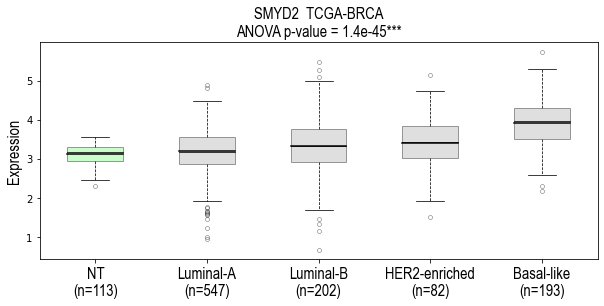

In [11]:
fig = plt.figure(figsize=(2*len(group_names), 4))
ax = fig.add_subplot(111)
bplot = ax.boxplot(boxplot_data, **boxplot_options)
for patch, group_name in zip(bplot['boxes'], group_names):
    patch.set_facecolor('palegreen' if group_name=='NT' else 'silver')
    patch.set_alpha(0.5)
title = gene_name + '  ' + dataset_name + '\nANOVA p-value = {:.1e}'.format(anova_pvalue) + get_significance_symbol(anova_pvalue)
ax.set_title(title, **font)
ax.set_ylabel('Expression', **font)
xticks = [i+1 for i in range(len(group_names))]
ax.set_xticks(xticks)
xticklabels = []
for group_name in group_names:
        group_samples = project['datasets'][dataset_name]['groups'][group_name]
        xticklabels.append(f"{group_name}\n(n={len(group_samples)})")
t = ax.set_xticklabels(xticklabels, **font)

In [12]:
# fig.savefig(f"figs/anova_{gene_name}_{dataset_name}.pdf", dpi=300, format='pdf', bbox_inches='tight', orientation='portrait')